<a href="https://colab.research.google.com/github/Elshraby/GradProj2/blob/main/12_May_BasicModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

import pandas as pd
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset

class VAWTDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        self.data.dropna(inplace=True)

        self.num_feature_columns = [
            'Number of Blades', 'Cord Length', 'Height',
            'Diameter', 'Pitch Angle', 'Freestream Velocity', 'Tip Speed Ratio'
        ]
        self.airfoil_column = 'Airfoil'
        self.target_column = 'Power Coefficient'

        self.num_features = self.data[self.num_feature_columns].values.astype(np.float32)
        airfoil_cat = self.data[self.airfoil_column].astype('category')
        self.airfoil_type = airfoil_cat.cat.codes.values.astype(np.int64)
        self.airfoil_mapping = dict(enumerate(airfoil_cat.cat.categories))
        self.targets = self.data[self.target_column].values.astype(np.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {
            'num_features': torch.tensor(self.num_features[idx]),
            'airfoil_type': torch.tensor(self.airfoil_type[idx]),
            'target': torch.tensor(self.targets[idx])
        }

class StandardVAWTNet(nn.Module):
    def __init__(self, num_feature_size, airfoil_vocab_size, emb_size=4, hidden_size=128):
        super(StandardVAWTNet, self).__init__()
        self.airfoil_embedding = nn.Embedding(airfoil_vocab_size, emb_size)
        input_size = num_feature_size + emb_size

        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, 1)
        )

    def forward(self, num_features, airfoil_type):
        emb = self.airfoil_embedding(airfoil_type)
        combined = torch.cat([num_features, emb], dim=1)
        return self.model(combined)

In [7]:
import torch.optim as optim
import json
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def train_model(model, train_loader, val_loader, num_epochs=500, learning_rate=1e-3):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch in train_loader:
            inputs = batch['num_features']
            airfoil_types = batch['airfoil_type']
            targets = batch['target']

            optimizer.zero_grad()
            outputs = model(inputs, airfoil_types)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_running_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                inputs = batch['num_features']
                airfoil_types = batch['airfoil_type']
                targets = batch['target']
                outputs = model(inputs, airfoil_types)
                loss = criterion(outputs, targets)
                val_running_loss += loss.item()
        val_loss = val_running_loss / len(val_loader)
        val_losses.append(val_loss)

        if (epoch+1) % 50 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

    print("Training complete.")

    # Plot training and validation loss
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Training vs. Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [8]:
def save_model(model, filepath='vawt_model.pth', metadata_file='model_metadata.json', **hyperparams):
    clean_hyperparams = {k: int(v) if isinstance(v, (np.integer, np.int64)) else v for k, v in hyperparams.items()}
    torch.save(model.state_dict(), filepath)
    with open(metadata_file, 'w') as f:
        json.dump(clean_hyperparams, f, indent=4)
    print(f"Model and metadata saved successfully.")

def load_model(model_class, model_filepath='vawt_model.pth', metadata_filepath='model_metadata.json'):
    with open(metadata_filepath, 'r') as f:
        hyperparams = json.load(f)
    model = model_class(
        num_feature_size=hyperparams["num_feature_size"],
        airfoil_vocab_size=hyperparams["airfoil_vocab_size"],
        emb_size=hyperparams["emb_size"],
        hidden_size=hyperparams["hidden_size"]
    )
    model.load_state_dict(torch.load(model_filepath))
    model.eval()
    print("Model loaded successfully.")
    return model

def predict(model, sample_num_features, sample_airfoil_name, airfoil_mapping):
    code_lookup = {v: k for k, v in airfoil_mapping.items()}
    if sample_airfoil_name not in code_lookup:
        raise ValueError(f"Airfoil '{sample_airfoil_name}' not recognized. Available: {list(code_lookup.keys())}")
    airfoil_code = code_lookup[sample_airfoil_name]
    model.eval()
    with torch.no_grad():
        num_features_tensor = torch.tensor([sample_num_features], dtype=torch.float32)
        airfoil_tensor = torch.tensor([airfoil_code], dtype=torch.int64)
        prediction = model(num_features_tensor, airfoil_tensor)
    return prediction.item()

def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in dataloader:
            inputs = batch['num_features']
            airfoil_types = batch['airfoil_type']
            targets = batch['target']
            outputs = model(inputs, airfoil_types)
            y_true.append(targets.numpy())
            y_pred.append(outputs.numpy())
    y_true = np.vstack(y_true).flatten()
    y_pred = np.vstack(y_pred).flatten()
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"MAE: {mae:.6f}, MSE: {mse:.6f}, RMSE: {rmse:.6f}, R²: {r2:.6f}")
    return mae, mse, rmse, r2

Epoch [50/1000], Train Loss: 0.004165, Val Loss: 0.004287
Epoch [100/1000], Train Loss: 0.002031, Val Loss: 0.002399
Epoch [150/1000], Train Loss: 0.001322, Val Loss: 0.002253
Epoch [200/1000], Train Loss: 0.001087, Val Loss: 0.001887
Epoch [250/1000], Train Loss: 0.000945, Val Loss: 0.001750
Epoch [300/1000], Train Loss: 0.000762, Val Loss: 0.001472
Epoch [350/1000], Train Loss: 0.000605, Val Loss: 0.001371
Epoch [400/1000], Train Loss: 0.000568, Val Loss: 0.001256
Epoch [450/1000], Train Loss: 0.000520, Val Loss: 0.001276
Epoch [500/1000], Train Loss: 0.000514, Val Loss: 0.001221
Epoch [550/1000], Train Loss: 0.000476, Val Loss: 0.001121
Epoch [600/1000], Train Loss: 0.000539, Val Loss: 0.001178
Epoch [650/1000], Train Loss: 0.000444, Val Loss: 0.001082
Epoch [700/1000], Train Loss: 0.000384, Val Loss: 0.001269
Epoch [750/1000], Train Loss: 0.000377, Val Loss: 0.001137
Epoch [800/1000], Train Loss: 0.000359, Val Loss: 0.001288
Epoch [850/1000], Train Loss: 0.000399, Val Loss: 0.00119

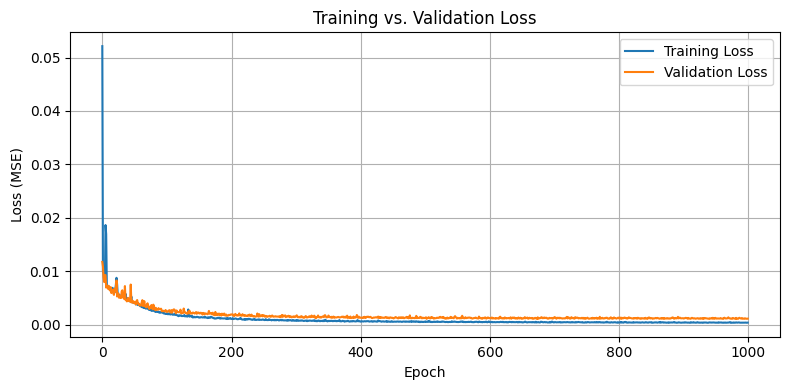

Model and metadata saved successfully.
MAE: 0.020475, MSE: 0.001110, RMSE: 0.033311, R²: 0.918922


(0.02047525905072689,
 0.00110964709892869,
 np.float64(0.03331136591208307),
 0.9189220666885376)

In [9]:
# Load dataset
dataset = VAWTDataset('Data.csv')
input_dim = len(dataset.num_feature_columns)
airfoil_vocab_size = int(dataset.airfoil_type.max()) + 1

# Split indices
indices = list(range(len(dataset)))
train_idx, val_idx = train_test_split(indices, test_size=0.2, random_state=RANDOM_SEED)
train_loader = DataLoader(Subset(dataset, train_idx), batch_size=32, shuffle=True)
val_loader = DataLoader(Subset(dataset, val_idx), batch_size=32, shuffle=False)

# Initialize and train model
model = StandardVAWTNet(input_dim, airfoil_vocab_size)
train_model(model, train_loader, val_loader, num_epochs=1000, learning_rate=1e-3)

# Save model
hyperparams = {
    "num_feature_size": int(input_dim),
    "airfoil_vocab_size": int(airfoil_vocab_size),
    "emb_size": 4,
    "hidden_size": 128,
}
save_model(model, **hyperparams)

# Evaluate
evaluate_model(model, val_loader)

In [10]:
# Reload dataset
dataset = VAWTDataset('Data.csv')

# Load model
model = load_model(StandardVAWTNet)

# Predict
sample_num_features = [3, 0.18, 0.4, 0.42, 0, 7.0, 0.80356]
sample_airfoil_name = "EN0005"
predicted_Cp = predict(model, sample_num_features, sample_airfoil_name, dataset.airfoil_mapping)
print(f"Predicted Cp: {predicted_Cp:.4f}")

Model loaded successfully.
Predicted Cp: 0.1451
